<a href="https://colab.research.google.com/github/jresendiz27/xss_sqli_detector/blob/main/00_01_CreatingFeatures_XSS_SQLi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Starting the Feature Creation (dataset level)

### Now, let's start creating some features!
We will take some inspiration on the OWASP coreruleset repository for diagnosing XSS and SQLi injection attacks
They provide some configurations for apache just as a plug-n-play and reject requests based on certain regexes.
* [Corerules XSS configurations](https://github.com/coreruleset/coreruleset/blob/main/rules/REQUEST-941-APPLICATION-ATTACK-XSS.conf)
* [Corerules SQLi configurations](https://github.com/coreruleset/coreruleset/blob/main/rules/REQUEST-942-APPLICATION-ATTACK-SQLI.conf)


Using those rules, we will create features for the dataset and update it as needed

In [1]:
# Install extra dependencies
# !pip install -r https://raw.githubusercontent.com/jresendiz27/xss_sqli_detector/refs/heads/main/extra_requirements.txt


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [1]:
# Basic imports
import re

import libinjection
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from pandarallel import pandarallel

pandarallel.initialize(nb_workers=24, progress_bar=False, verbose=5, use_memory_fs=False)

# Adjusting for localhost or google colab
STORAGE_PATH = './datasets/raw'
try:
    from google.colab import drive

    drive.mount('/content/drive')
    STORAGE_PATH = '/content/drive/MyDrive/xss_sqli_detector/datasets'
except:
    print('Not running on Google Colab')

XSS_SQLI_CONDENSED_DATASET_PATH = f'{STORAGE_PATH}/xss_sqli_condensed.csv'

INFO: Pandarallel will run on 24 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
Not running on Google Colab


In [26]:
df_xss_sqli = pd.read_csv(XSS_SQLI_CONDENSED_DATASET_PATH)

In [3]:
df_xss_sqli.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 273705 entries, 0 to 273704
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   payload       273704 non-null  object
 1   label         273705 non-null  int64 
 2   attack_label  273705 non-null  object
 3   type          273705 non-null  object
dtypes: int64(1), object(3)
memory usage: 8.4+ MB


In [30]:
df_xss_sqli = df_xss_sqli[(df_xss_sqli['payload'].isna() == False)]
df_xss_sqli.info()

<class 'pandas.core.frame.DataFrame'>
Index: 273704 entries, 0 to 273704
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   payload       273704 non-null  object
 1   label         273704 non-null  int64 
 2   attack_label  273704 non-null  object
 3   type          273704 non-null  object
dtypes: int64(1), object(3)
memory usage: 10.4+ MB


In [39]:
# Quick wins validations
JS_RESERVED_WORDS = [
    "keys", "in", "throw", "alert", "do", "finally", "console", "for", "setTimeout", "data", "break", "apply", "null",
    "super", "typeof", "while", "Object", "import", "extends", "__proto__", "parseHTMLUnsafe", "return", "interface",
    "package", "static", "DOMParser", "date", "setInterval", "debugger", "with", "const", "instanceof", "prototype",
    "setAttribute", "createContextualFragment", "public", "implements", "valueOf", "stringify", "js", "let", "void",
    "assign", "false", "switch", "function", "escape", "var", "base64", "bind", "outerHTML", "else", "props", "yield",
    "default", "defineProperties", "catch", "private", "new", "protected", "document", "eval", "call", "class", "enum",
    "export", "continue", "this", "true", "if", "insertAdjacentHTML", "delete", "try", "parseJSON", "innerHTML",
    "__prototype__", "window", "await", "prompt", "location", "case", "length", "json", "setHTMLUnsafe"
]
SQL_RESERVED_WORDS = [
    "select", "insert", "update", "delete", "from", "where", "join", "inner", "left", "right", "full", "outer", "on",
    "group", "by", "order", "limit", "offset", "having", "distinct",
    "create", "alter", "drop", "table", "index", "view", "database", "schema",
    "primary", "key", "foreign", "references",
    "into", "values", "set",
    "and", "or", "not", "null", "is", "in", "between", "like", "ilike", "exists",
    "union", "all", "case", "when", "then", "else", "end", "as", "using", "top", "json", "jsonschema", "jsonb",
    "procedure", "stored"
]

HTML_RESERVED_TAGS = [
    "html", "head", "body", "title", "meta", "link", "style", "script",
    "div", "span", "p", "a", "img", "ul", "ol", "li", "nav", "header", "footer", "main", "section", "article", "aside",
    "h1", "h2", "h3", "h4", "h5", "h6",
    "form", "input", "textarea", "button", "select", "option", "label", "fieldset", "legend", "datalist", "output",
    "table", "thead", "tbody", "tfoot", "tr", "th", "td", "caption", "col", "colgroup",
    "figure", "figcaption", "picture", "source", "track",
    "small", "strong", "em", "b", "i", "u", "code", "pre", "kbd", "samp", "blockquote", "q", "cite", "time", "mark",
    "abbr", "address",
    "hr", "br", "video", "audio", "canvas", "svg", "path", "g", "iframe", "template", "slot"
]

COMMON_WEB_SINKS = [
    "eval", "Function", "setTimeout", "setInterval", "innerHTML", "outerHTML", "insertAdjacentHTML",
    "document.write", "document.writeln",
    "DOMParser.parseFromString", "createContextualFragment",
    "setHTMLUnsafe", "parseHTMLUnsafe", "setAttribute", "srcdoc", "href", "src", "action", "formAction", "window.open",
    "location", "location.href", "location.assign", "location.replace",
]

JS_WORDS_PATTERN = r"(?i)\b(?:" + "|".join(map(re.escape, JS_RESERVED_WORDS)) + r")\b"
SQL_WORDS_PATTERN = r"(?i)\b(?:" + "|".join(map(re.escape, SQL_RESERVED_WORDS)) + r")\b"
HTML_WORDS_PATTERN = r"(?i)\b(?:" + "|".join(map(re.escape, HTML_RESERVED_TAGS)) + r")\b"
COMMON_SINK_PATTERN = r"(?i)\b(?:" + "|".join(map(re.escape, COMMON_WEB_SINKS)) + r")\b"
SPECIAL_CHARS_STR_PATTERN = r'[-+<>;{}&"\'/^$\~[\]%`@.,*#|]'

QUICK_WINS_PATTERNS = {
    'special_chars_count': re.compile(SPECIAL_CHARS_STR_PATTERN, re.S),
    'http_word_count': re.compile(r'(?i)\b(?:https?:)?//[^\s"\'<>()]+', re.I | re.S),
    'reserved_sql_words_count': re.compile(SQL_WORDS_PATTERN, re.I | re.S),
    'reserved_js_words_count': re.compile(JS_WORDS_PATTERN, re.I | re.S),
    'reserved_web_sink_count': re.compile(COMMON_SINK_PATTERN, re.I | re.S),
}


In [54]:
## Creating new features for XSS considering CoreRulesSet Regexes for XSS/SQLi

# Extracted from CoreRuleSet repository
## XSS Related
XSS_REGEX_PATTERNS = {
    'contains_script_tag': re.compile(r'(?i)<script[^>]*>[\s\S]*?', re.I | re.S),
    'contains_cookie_related': re.compile(
        r'(?:document\.cookie|document\.domain|document\.querySelector|document\.body\.appendChild|document\.write|\.parentnode|\.innerhtml|window\.location|-moz-binding|<!--|<!\[cdata\[|\\)',
        re.I | re.S),
    'contains_xss_ascii_malformed': re.compile(r'\xbc[^\xbe>]*[\xbe>]|<[^\xbe]*\xbe|\+ADw-.*(?:\+AD4-|>)|<.*\+AD4-',
                                               re.I | re.S),
}

# SQLI REGEX PATTERNS
SQLI_REGEX_PATTERNS = {
    'contains_sql_operators': re.compile(
        r'(?i)[!=]=|&&|\|\||->|>[=>]|<(?:[<=]|>(?:[\s\x0b]+binary)?)|\b(?:(?:xor|r(?:egexp|like)|i(?:snull|like)|notnull)\b|collate(?:[^0-9A-Z_a-z]*?(?:U&)?[\"\'`]|[^0-9A-Z_a-z]+(?:(?:binary|nocase|rtrim)\b|[0-9A-Z_a-z]*?_))|(?:likel(?:ihood|y)|unlikely)[\s\x0b]*\()|r(?:egexp|like)[\s\x0b]+binary|not[\s\x0b]+between[\s\x0b]+(?:0[\s\x0b]+and|(?:\'[^\']*\'|\"[^\"]*\")[\s\x0b]+and[\s\x0b]+(?:\'[^\']*\'|\"[^\"]*\"))|is[\s\x0b]+null|like[\s\x0b]+(?:null|[0-9A-Z_a-z]+[\s\x0b]+escape\b)|(?:^|[^0-9A-Z_a-z])in[\s\x0b\+]*\([\s\x0b\"0-9]+[^\(\)]*\)|[!<->][\s\x0b]*all\b',
        re.I | re.S),
    'contains_sql_functions': re.compile(
        r'(?i)\b(?:a(?:dd(?:dat|tim)e|es_(?:de|en)crypt|s(?:cii(?:str)?|in)|tan2?)|b(?:enchmark|i(?:n_to_num|t_(?:and|count|length|x?or)))|c(?:har(?:acter)?_length|iel(?:ing)?|o(?:alesce|ercibility|llation|(?:mpres)?s|n(?:cat(?:_ws)?|nection_id|v(?:ert_tz)?)|t)|r32|ur(?:(?:dat|tim)e|rent_(?:date|setting|time(?:stamp)?|user)))|d(?:a(?:t(?:abase(?:_to_xml)?|e(?:_(?:add|format|sub)|diff))|y(?:name|of(?:month|week|year)))|count|e(?:code|s_(?:de|en)crypt)|ump)|e(?:n(?:c(?:ode|rypt)|ds_?with)|x(?:p(?:ort_set)?|tract(?:value)?))|f(?:i(?:el|n)d_in_set|ound_rows|rom_(?:base64|days|unixtime))|g(?:e(?:ometrycollection|t(?:_(?:format|lock)|pgusername))|(?:r(?:eates|oup_conca)|tid_subse)t)|hex(?:toraw)?|i(?:fnull|n(?:et6?_(?:aton|ntoa)|s(?:ert|tr)|terval)|s(?:_(?:(?:free|used)_lock|ipv(?:4(?:_(?:compat|mapped))?|6)|n(?:ot(?:_null)?|ull)|superuser)|null))|json(?:_(?:a(?:gg|rray(?:_(?:elements(?:_text)?|length))?)|build_(?:array|object)|e(?:ac|xtract_pat)h(?:_text)?|object(?:_(?:agg|keys))?|populate_record(?:set)?|strip_nulls|t(?:o_record(?:set)?|ypeof))|b(?:_(?:array(?:_(?:elements(?:_text)?|length))?|build_(?:array|object)|e(?:ac|xtract_pat)h(?:_text)?|insert|object(?:_(?:agg|keys))?|p(?:ath_(?:(?:exists|match)(?:_tz)?|query(?:_(?:(?:array|first)(?:_tz)?|tz))?)|opulate_record(?:set)?|retty)|s(?:et(?:_lax)?|trip_nulls)|t(?:o_record(?:set)?|ypeof)))?|path)?|l(?:ast_(?:day|inser_id)|case|east|i(?:kely|nestring)|o(?:_(?:from_bytea|put)|ad_file|ca(?:ltimestamp|te)|g(?:10|2))|pad|trim)|m(?:a(?:ke(?:_set|date)|ster_pos_wait)|d5|i(?:crosecon)?d|onthname|ulti(?:linestring|po(?:int|lygon)))|n(?:ame_const|ot_in|ullif)|o(?:ct(?:et_length)?|(?:ld_passwo)?rd)|p(?:eriod_(?:add|diff)|g_(?:client_encoding|(?:databas|read_fil)e|l(?:argeobject|s_dir)|sleep|user)|o(?:lygon|w)|rocedure_analyse)|qu(?:ery_to_xml|ote)|r(?:a(?:dians|nd|wtohex)|elease_lock|ow_(?:count|to_json)|pad|trim)|s(?:chema|e(?:c_to_time|ssion_user)|ha[12]?|in|oundex|q(?:lite_(?:compileoption_(?:get|used)|source_id)|rt)|t(?:arts_?with|d(?:dev_(?:po|sam)p)?|r(?:_to_date|cmp))|ub(?:(?:dat|tim)e|str(?:ing(?:_index)?)?)|ys(?:date|tem_user))|t(?:ime(?:_(?:format|to_sec)|diff|stamp(?:add|diff)?)|o(?:_(?:base64|jsonb?)|n?char|(?:day|second)s)|r(?:im|uncate))|u(?:case|n(?:compress(?:ed_length)?|hex|i(?:str|x_timestamp))|(?:pdatexm|se_json_nul)l|tc_(?:date|time(?:stamp)?)|uid(?:_short)?)|var(?:_(?:po|sam)p|iance)|we(?:ek(?:day|ofyear)|ight_string)|xmltype|yearweek)[^0-9A-Z_a-z]*\(',
        re.I | re.S),
    'contains_sql_tautologies': re.compile(
        r'(?i)[\s\x0b\"\'-\)`]*?\b([0-9A-Z_a-z]+)\b[\s\x0b\"\'-\)`]*?(?:=|<=>|(?:sounds[\s\x0b]+)?like|glob|r(?:like|egexp))[\s\x0b\"\'-\)`]*?\b([0-9A-Z_a-z]+)\b',
        re.I | re.S),
}


def _safe_libinjection_validation(type: str, payload: str) -> int:
    if not isinstance(payload, str) or not payload:
        return 0
    try:
        if type == 'is_xss':
            if libinjection.is_xss(payload).get('is_xss', False):
                return 1
            else:
                return 0
        else:
            if libinjection.is_sql_injection(payload).get('is_sqli', False):
                return 1
            else:
                return 0
    except Exception:
        return 0


def eval_all_values(text: str) -> pd.Series:
    s = text if isinstance(text, str) else ''
    all_regex_patterns: dict[str, re.Pattern] = {**XSS_REGEX_PATTERNS, **SQLI_REGEX_PATTERNS, **QUICK_WINS_PATTERNS}

    out: dict[str, int] = {}
    for name, rx in all_regex_patterns.items():
        if "count" in name:
            out[name] = len(rx.findall(s))
        else:
            out[name] = 1 if rx.match(s) else 0

    is_xss = _safe_libinjection_validation('is_xss', s)
    is_sqli = _safe_libinjection_validation('is_sqli', s)
    out['detected_by_libinjection'] = is_xss or is_sqli
    return pd.Series(out)


In [55]:
df_xss_sqli['payload_length'] = df_xss_sqli['payload'].str.len()
df_xss_sqli['label_type'] = df_xss_sqli['type'].map({'Benign': 0, 'Malicious': 1})
xss_sqli_new_columns = df_xss_sqli['payload'].parallel_apply(eval_all_values)

In [56]:
xss_sqli_new_columns.info()

<class 'pandas.core.frame.DataFrame'>
Index: 273704 entries, 0 to 273704
Data columns (total 12 columns):
 #   Column                        Non-Null Count   Dtype
---  ------                        --------------   -----
 0   contains_script_tag           273704 non-null  int64
 1   contains_cookie_related       273704 non-null  int64
 2   contains_xss_ascii_malformed  273704 non-null  int64
 3   contains_sql_operators        273704 non-null  int64
 4   contains_sql_functions        273704 non-null  int64
 5   contains_sql_tautologies      273704 non-null  int64
 6   special_chars_count           273704 non-null  int64
 7   http_word_count               273704 non-null  int64
 8   reserved_sql_words_count      273704 non-null  int64
 9   reserved_js_words_count       273704 non-null  int64
 10  reserved_web_sink_count       273704 non-null  int64
 11  detected_by_libinjection      273704 non-null  int64
dtypes: int64(12)
memory usage: 27.1 MB


In [57]:
df_xss_sqli_with_features = pd.concat([df_xss_sqli, xss_sqli_new_columns], axis=1)

In [58]:
df_xss_sqli_with_features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 273704 entries, 0 to 273704
Data columns (total 18 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   payload                       273704 non-null  object
 1   label                         273704 non-null  int64 
 2   attack_label                  273704 non-null  object
 3   type                          273704 non-null  object
 4   payload_length                273704 non-null  int64 
 5   label_type                    273704 non-null  int64 
 6   contains_script_tag           273704 non-null  int64 
 7   contains_cookie_related       273704 non-null  int64 
 8   contains_xss_ascii_malformed  273704 non-null  int64 
 9   contains_sql_operators        273704 non-null  int64 
 10  contains_sql_functions        273704 non-null  int64 
 11  contains_sql_tautologies      273704 non-null  int64 
 12  special_chars_count           273704 non-null  int64 
 13  http

In [59]:
df_xss_sqli_with_features.to_csv(f'{STORAGE_PATH}/xss_sqli_condensed_with_features.csv')

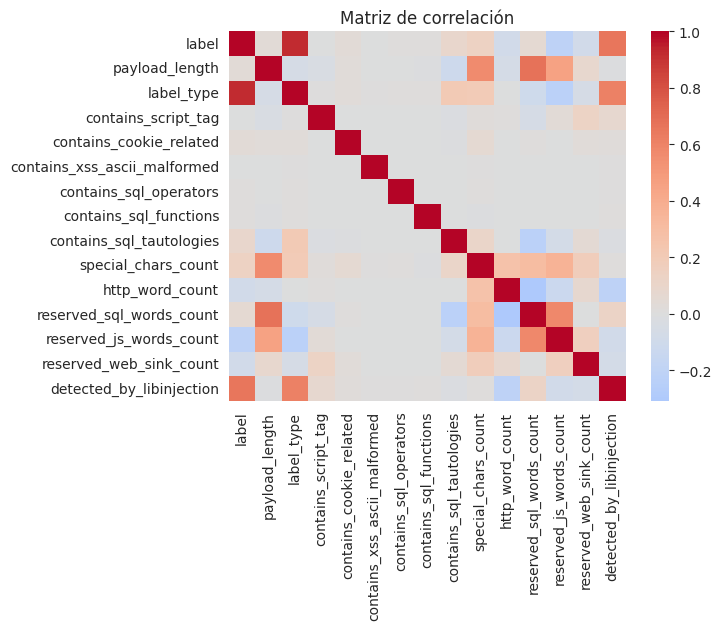

In [60]:
num_cols = df_xss_sqli_with_features.select_dtypes(include=[np.number]).columns.tolist()

corr = df_xss_sqli_with_features[num_cols].corr(method="spearman")
sns.heatmap(corr, cmap="coolwarm", center=0, annot=False)
plt.title("Matriz de correlación")
plt.show()

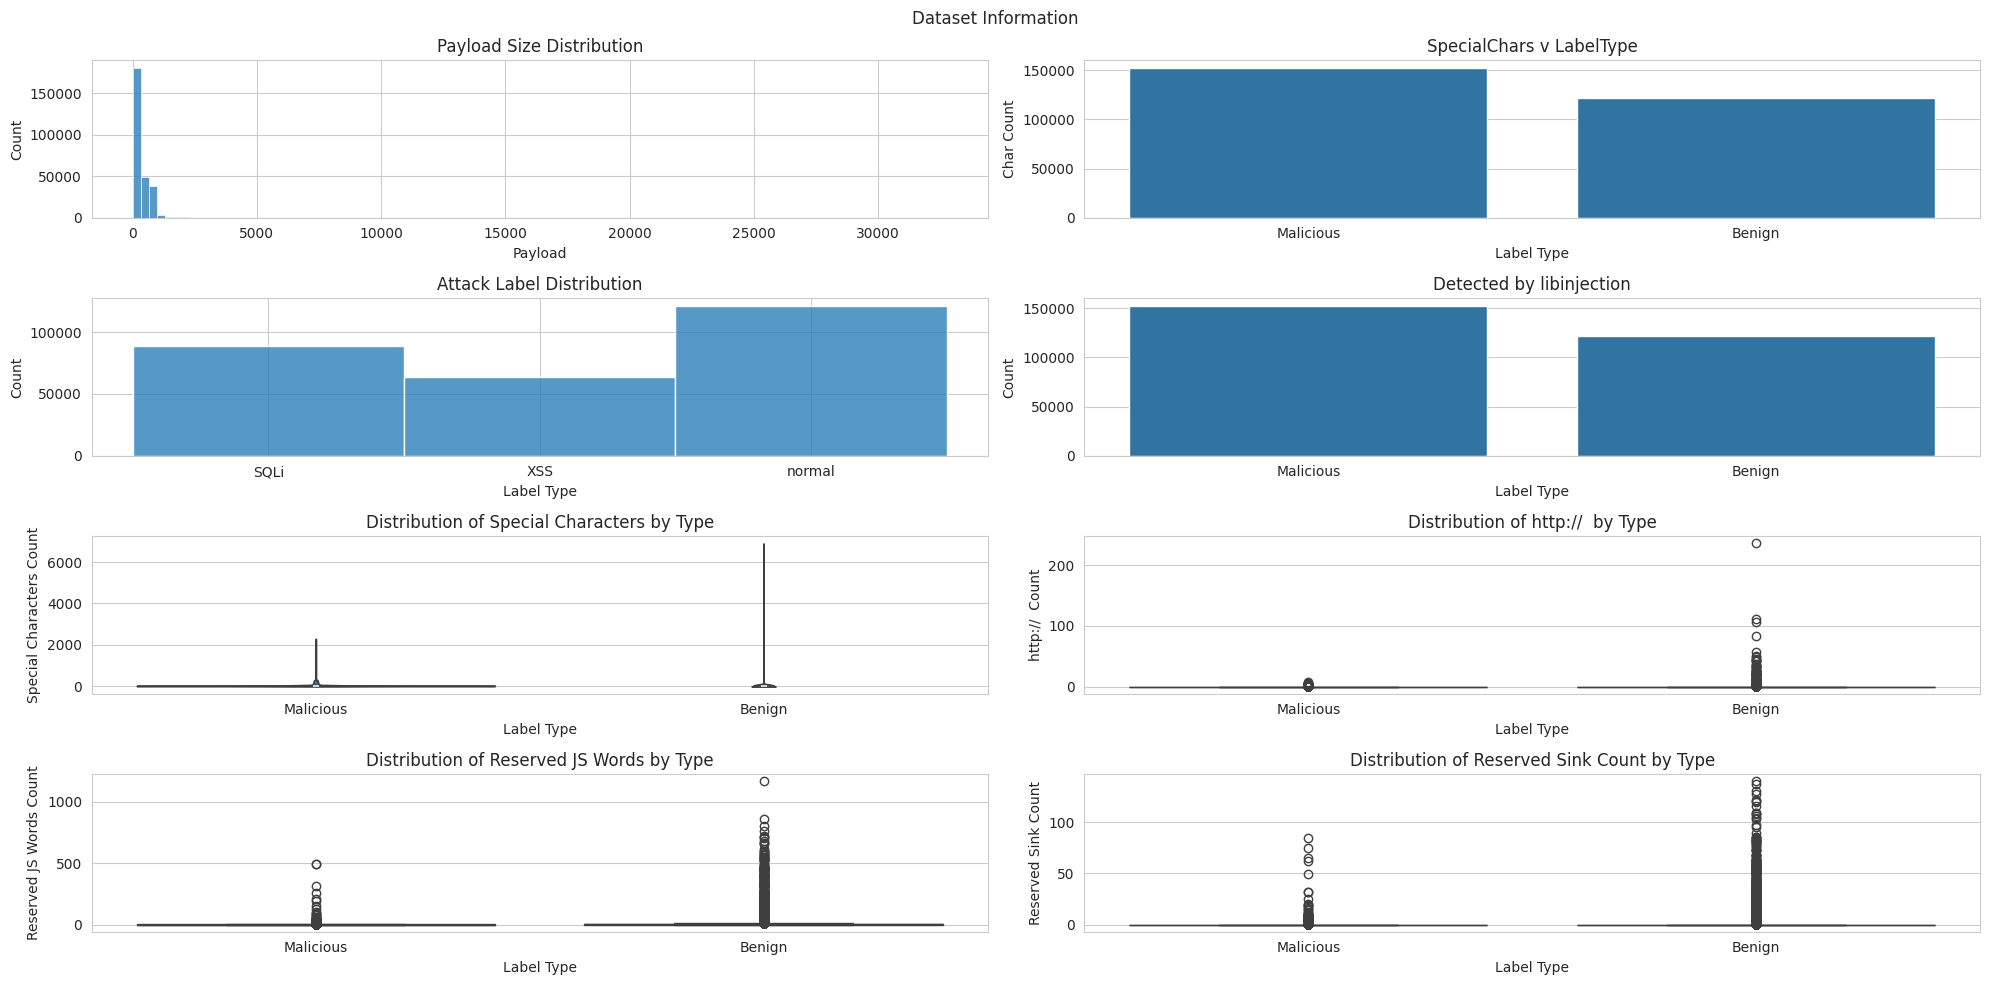

In [61]:
fig, axes = plt.subplots(4, 2, figsize=(20, 10))

flattened_axes = axes.flatten()

fig.suptitle("Dataset Information")

sns.histplot(ax=flattened_axes[0], data=df_xss_sqli_with_features, x="payload_length", bins=100)
flattened_axes[0].set(xlabel="Payload")
flattened_axes[0].set_title('Payload Size Distribution')

sns.barplot(ax=flattened_axes[1], data=df_xss_sqli_with_features, x="type", y="special_chars_count", estimator="size")
flattened_axes[1].set_xlabel('Label Type')
flattened_axes[1].set_ylabel('Char Count')
flattened_axes[1].set_title('SpecialChars v LabelType')

sns.histplot(ax=flattened_axes[2], data=df_xss_sqli_with_features, x="attack_label")
flattened_axes[2].set_xlabel('Label Type')
flattened_axes[2].set_ylabel('Count')
flattened_axes[2].set_title('Attack Label Distribution')

# Detection by libinjection
sns.barplot(ax=flattened_axes[3], data=df_xss_sqli_with_features, x="type", y='detected_by_libinjection',
            estimator="size")
flattened_axes[3].set_xlabel('Label Type')
flattened_axes[3].set_ylabel('Count')
flattened_axes[3].set_title('Detected by libinjection')

# Special Chars by benign and Malicious
sns.violinplot(ax=flattened_axes[4], data=df_xss_sqli_with_features, x="type", y='special_chars_count')
flattened_axes[4].set_xlabel('Label Type')
flattened_axes[4].set_ylabel('Special Characters Count')
flattened_axes[4].set_title('Distribution of Special Characters by Type')

# html word count by type
sns.boxplot(ax=flattened_axes[5], data=df_xss_sqli_with_features, x="type", y='http_word_count')
flattened_axes[5].set_xlabel('Label Type')
flattened_axes[5].set_xlabel('Label Type')
flattened_axes[5].set_ylabel('http://  Count')
flattened_axes[5].set_title('Distribution of http://  by Type')

# js word count by type
sns.boxplot(ax=flattened_axes[6], data=df_xss_sqli_with_features, x="type", y='reserved_js_words_count')
flattened_axes[6].set_xlabel('Label Type')
flattened_axes[6].set_ylabel('Reserved JS Words Count')
flattened_axes[6].set_title('Distribution of Reserved JS Words by Type')

# SINK word count by type
sns.boxplot(ax=flattened_axes[7], data=df_xss_sqli_with_features, x="type", y='reserved_web_sink_count')
flattened_axes[7].set_xlabel('Label Type')
flattened_axes[7].set_ylabel('Reserved Sink Count')
flattened_axes[7].set_title('Distribution of Reserved Sink Count by Type')

plt.tight_layout()
plt.show()